<a href="https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/QUICKSTART_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [ ]:
!pip install rapidae

This installs the latest stable version. If you want to have control over the code you can check the [execute_from_source_code](https://colab.research.google.com/github/NahuelCostaCortez/rapidae/blob/main/examples/execute_from_source_code.ipynb) notebook.

You will also need to install a backend framework

**If you are executing this from colab you can skip this process**, Tensorflow, Pytorch and JAX are already installed.

#### Install tensorflow

In [ ]:
!python3 -m pip install tensorflow[and-cuda]

After installing tensorflow Keras 3 should be re-installed. This is a temporary step while TensorFlow is pinned to Keras 2, and will no longer be necessary after TensorFlow 2.16. The cause is that tensorflow==2.15 will overwrite your Keras installation with keras==2.15.

In [ ]:
!pip install --upgrade keras

#### Install pytorch

In [ ]:
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118

#### Install JAX

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]" # CPU-only version
# pip install --upgrade "jax[cuda11_pip]" # NVIDIA GPU version

### Data

Let´s start loading some data.

You can list the available datasets with the ```list_datasets()``` function. More datasets will be added soon.

In [2]:
from rapidae.data import list_datasets, load_dataset, load_MNIST

In [3]:
list_datasets()

['CMAPSS', 'MNIST', 'AtrialFibrillation']

There are two options for loading a dataset:

1. Use the load_dataset function with the dataset name

In [4]:
data = load_dataset('MNIST')

2024-01-31 12:08:18 [INFO]: Downloading train-images-idx3-ubyte.gz...


2024-01-31 12:08:19 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-01-31 12:08:19 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-01-31 12:08:19 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-01-31 12:08:20 [INFO]: Deleting MNIST data...


2. Use the load_"dataset_name" function. 

In [5]:
data = load_MNIST()

2024-01-31 12:08:21 [INFO]: Downloading train-images-idx3-ubyte.gz...


2024-01-31 12:08:22 [INFO]: Downloading train-labels-idx1-ubyte.gz...
2024-01-31 12:08:22 [INFO]: Downloading t10k-images-idx3-ubyte.gz...
2024-01-31 12:08:22 [INFO]: Downloading t10k-labels-idx1-ubyte.gz...
2024-01-31 12:08:23 [INFO]: Deleting MNIST data...


All datasets have a "persistant" parameter. If set to True stores the data in a newly created "datasets" folder. By default it is set to False.

```
data = load_dataset('MNIST', persistant=True)
data = load_MNIST(persistant=True)
```

All datasets return a dictionary with can contain any of the following keys:
- x_train
- x_val
- x_test
- y_train
- y_val
- y_test

In [6]:
data.keys()

dict_keys(['x_train', 'y_train', 'x_test', 'y_test'])

Prepare data for training:
- Normalize data in the range [0,1]
- Flatten data -> in this case we are going to use an autoencoder with an encoder whose first layer is a Dense layer so it needs to have the following shape: (samples, features)
- Convert labels to categorical

In [ ]:
from keras import utils

# Normalize data and flatten images
x_train = data['x_train'].reshape(data['x_train'].shape[0], -1).astype("float32") / 255
x_test = data['x_test'].reshape(data['x_test'].shape[0], -1).astype("float32") / 255

input_dim = x_train.shape[1]

# Convert labels to categorical
n_classes = len(set(data['y_train']))
y_train = utils.to_categorical(data['y_train'], n_classes)
y_test = utils.to_categorical(data['y_test'], n_classes)

### Models

You can list the available models with the ```list_models()``` function.

Note however, that these are the base models, for a complete guide of the implemented models, please refer to the documentation or to the README of the official repo.

In [16]:
from rapidae.models import list_models

In [9]:
list_models()

['AE', 'BASE', 'CAE', 'RVE', 'VAE', 'VQ_VAE']

Let´s build a vanilla autoencoder.

Each model needs typically an encoder and a decoder (some models actually don´t, but let´s skip that part for now). You can select among the available architectures in the models module or provide your own implementation.

#### 1. Selecting an existing architecture

In [10]:
from rapidae.models import AE

Each model has at least the following parameters:

- input_dim (Union[Tuple[int, ...], None]): The dimensionality of the input data. Default is None. **Required parameter**.
    This typically is:
    - If time series: series_len, num_features
    - If image: width, height, num_channels
    - If the selected model uses a Dense layer as the first layer it should be the product of those dimensions. In this case, for instance, width=28, height=28, num_channels=1 therefore the input_dim is 28x28x1=784
- latent_dim (int): The dimensionality of the latent space. Default is 2.
- encoder (BaseEncoder): An instance of BaseEncoder. Default is None.
- decoder (BaseDecoder): An instance of BaseDecoder. Default is None.
- exclude_decoder (bool): Whether to exclude the decoder from the model. Default is False.
- layers_conf (list): The configuration of layers in the encoder and decoder architectures. Default is None. **Only applies for MLP architectures.**

You can notice that the input_dim is the only required parameter, which means you can instantiate a model just by doing:

In [11]:
model = AE(input_dim=input_dim)

2024-01-31 12:11:13 [WARNING]: No specific layer configuration has been provided. Creating default configuration: [512]...
2024-01-31 12:11:13 [WARNING]: No encoder provided, using default encoder
2024-01-31 12:11:13 [WARNING]: No decoder provided, using default decoder


Feel free to experiment with other parameters. For example, we can also set:
- latent_dim
- layers_conf: by setting [32,64,128] we specify that we want an encoder with 3 layers and the number of neurons for each layer should be 32 for the first, 64 for the second and 128 for the third. The decoder has the same structure but in reverse, that is, 3 layers with 128, 64, 32 neurons in each one.

In [12]:
model = AE(input_dim=input_dim, latent_dim=5, layers_conf=[32, 64, 128])

2024-01-31 12:12:00 [WARNING]: No encoder provided, using default encoder
2024-01-31 12:12:00 [WARNING]: No decoder provided, using default decoder


Finally, you can also select an existing architecture:

In [13]:
from rapidae.models.base import VanillaEncoder, VanillaDecoder

In [14]:
model = AE(input_dim=input_dim, encoder=VanillaEncoder, decoder=VanillaDecoder)

2024-01-31 12:12:15 [WARNING]: No specific layer configuration has been provided. Creating default configuration: [512]...


#### 2. Providing a custom architecture

Let's say you want another model architecture, then you would have to define it yourself, here is an example:

In [17]:
from rapidae.models.base import BaseEncoder, BaseDecoder
from keras.layers import Dense

class Custom_Encoder(BaseEncoder):
    def __init__(self, input_dim, latent_dim, **kwargs): # you can add more arguments, but al least these are required
        BaseEncoder.__init__(self, input_dim=input_dim, latent_dim=latent_dim)

        self.layer_1 = Dense(300)
        self.layer_2 = Dense(150)
        self.layer_3 = Dense(self.latent_dim)

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

class Custom_Decoder(BaseDecoder):
    def __init__(self, input_dim, latent_dim, **kwargs): # you can add more arguments, but al least these are required
        BaseDecoder.__init__(self, input_dim=input_dim, latent_dim=latent_dim)

        self.layer_1 = Dense(self.latent_dim)
        self.layer_2 = Dense(self.input_dim)

    def call(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

Now instantiate the model as before feeding the custom encoder and decoder

In [27]:
model = AE(input_dim=input_dim, encoder=Custom_Encoder, decoder=Custom_Decoder)

You can also provide a custom model. This is specially useful if you want to implement a customized loss function.

In [19]:
from rapidae.models.base import BaseAE
from keras.ops import mean
from keras.losses import mean_squared_error

class CustomModel(BaseAE):
    def __init__(self, input_dim, latent_dim, encoder, decoder):
        BaseAE.__init__(
            self,
            input_dim=input_dim,
            latent_dim=latent_dim,
            encoder=encoder,
            decoder=decoder
        )
        
    def call(self, x):
        # IMPLEMENT FORWARD PASS
        x = self.encoder(x)
        x = self.decoder(x)

        return x
      
    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        '''
        Computes the loss of the model.
        x: input data
        y: target data
        y_pred: predicted data (output of call)
        sample_weight: Optional array of the same length as x, containing weights to apply to the model's loss for each sample
        '''
        # IMPLEMENT LOSS FUNCTION
        loss = mean(mean_squared_error(x, y_pred))

        return loss

In [21]:
customModel = CustomModel(input_dim=input_dim, latent_dim=2, encoder=Custom_Encoder, decoder=Custom_Decoder)

### Training

The model is a keras model therefore you can directly use the ```.fit``` method.

The training pipeline allows you to configure training settings like managing callbacks or reloading the best parameters after tranining.

It has the following parameters:
- model (BaseAE): Autoencoder model to be trained.
- optimizer (str): Name of the optimizer.
- learning_rate (float): Learning rate for the optimizer.
- batch_size (int): Batch size for training.
- num_epochs (int): Number of training epochs.
- callbacks (list, optional): List of Keras callbacks. Defaults to None.
- save_model (bool, optional): Flag to save the trained model. Defaults to True.

In [22]:
from rapidae.pipelines import TrainingPipeline

In [28]:
pipe = TrainingPipeline(name='vanilla_autoencoder', learning_rate=0.001,
                        model=model, num_epochs=20, batch_size=128)

trained_model = pipe(x=x_train, y=x_train)

2024-01-31 12:37:20 [INFO]: +++ vanilla_autoencoder +++
2024-01-31 12:37:20 [INFO]: Creating folder in ./output_dir/vanilla_autoencoder_2024-01-31_12-37-20


Epoch 1/20

Epoch 1: loss improved from inf to 0.06504, saving model to ./output_dir/vanilla_autoencoder_2024-01-31_12-37-20/model.weights.h5
469/469 - 3s - 6ms/step - loss: 0.0650
Epoch 2/20

Epoch 2: loss improved from 0.06504 to 0.05759, saving model to ./output_dir/vanilla_autoencoder_2024-01-31_12-37-20/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0576
Epoch 3/20

Epoch 3: loss improved from 0.05759 to 0.05739, saving model to ./output_dir/vanilla_autoencoder_2024-01-31_12-37-20/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0574
Epoch 4/20

Epoch 4: loss improved from 0.05739 to 0.05721, saving model to ./output_dir/vanilla_autoencoder_2024-01-31_12-37-20/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0572
Epoch 5/20

Epoch 5: loss improved from 0.05721 to 0.05705, saving model to ./output_dir/vanilla_autoencoder_2024-01-31_12-37-20/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0571
Epoch 6/20

Epoch 6: loss improved from 0.05705 to 0.05690, saving model to ./o

2024-01-31 12:38:00 [INFO]: Restoring best model
2024-01-31 12:38:00 [INFO]: Best model restored


The plot_training_history plots the evolution of the metrics involved during training.

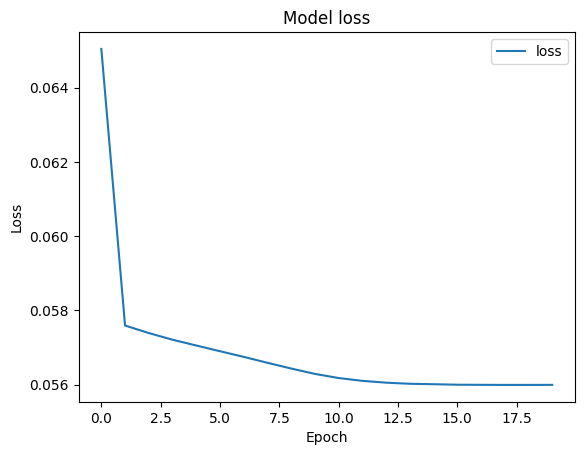

In [29]:
pipe.plot_training_history()

### Evaluation

Depending on what you are training the model for you can find different evaluations. For this example, we are going to focus on the decoder´s reconstructions as well as in the the visual evaluation of the latent space 

In [30]:
from rapidae.evaluate import plot_reconstructions, plot_latent_space

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


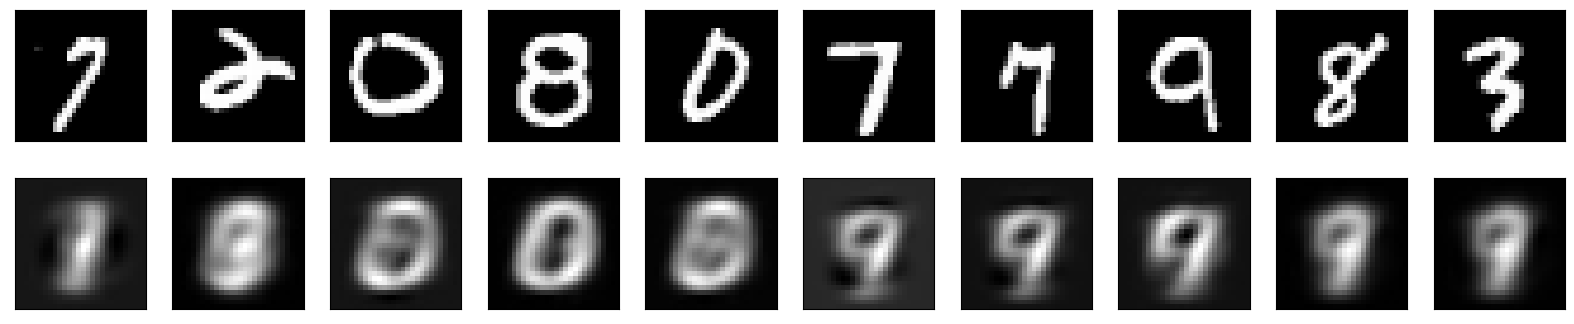

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [31]:
outputs = trained_model.predict(x_test)

plot_reconstructions(x_test, outputs['recon'])

It is clearly seen that the model needs more training!

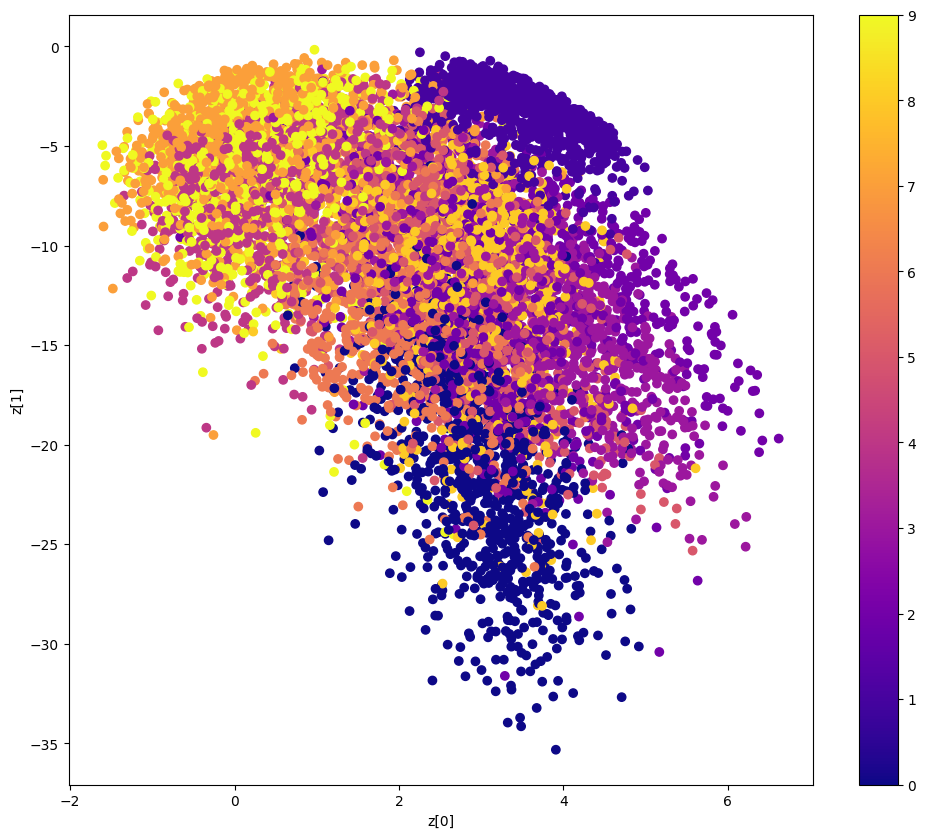

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [32]:
plot_latent_space(outputs['z'], y_test.argmax(axis=1))